# RAMP Urban trees: towards a clinical study

#### Authors: Agnimo Yedidia, Amadei Tristan, Boutier Martin, Klein Antoine, Latournerie Louis, Remmache Yanis

<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="center"; style="background-color:transparent; width: 40%;">
        <a href="https://github.com/AntoineTSP/Ramp_challenge">
            <img src="./img/Urban_trees.png" width="450px"/>
        </a>
    </td>
  </tr>
 </table>
</div>

## Table of Contents
* [Introduction](#introduction)
* [The dataset](#dataset)
* [Base model](#base_model)
* [Submitting on RAMP](#submitting)

## Introduction <a class="anchor" id="introduction"></a>
The living environment is a subject of growing public attention. Indeed, we all aspire to live in a clean, peaceful and non-artificial environment. In the urban environment, one of these issues is the greening of streets. In this respect, trees play a crucial role in welcoming urban biodiversity, brightening up the landscape and lowering summer temperatures during heatwaves.

Except that, like all living forms, these trees are not immutable and require monitoring and maintenance. The commune of Saint-Germain en Laye has been appointed to monitor the condition of its urban trees. The result is an open-source dataset <a href="https://www.data.gouv.fr/fr/datasets/arbres-urbains/"> (URL to the data.gouv website) </a> listing the positions, condition and species present on their territory.

We propose to use these measurements to assess the situation and carry out a study of the risks facing these trees. The aim is to gain a better understanding of the forces at work, so as to be in a better position to maintain this green heritage.

## The dataset <a class="anchor" id="dataset"></a>

This challenge contains a pdf file (legende-sgl-arbres-urbains.pdf) which explains the meaning of each abbreviation. We invite the reader to refer to them.
### Requirements

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

### Data
Let's inspect what we have !

In [2]:
# Source : https://www.data.gouv.fr/fr/datasets/arbres-urbains/
data = pd.read_csv('./data/sgl-arbres-urbains-wgs84.csv')
data.head(5)

,ID_ARBRE,commune,quartier,site,cote_voirie,matricule_arbre,genre_arbre,espece_arbre,controle,situation,...,observation_travaux,type_delai_1,delai_annee_programmation,type_delai_2,delai_preconisation_2,delai_saison_programmation_2,delai_annee_programmation_2,reference_photo,Long,Lat
0,78551-Arbres-001,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,7,Betula,Alba,NaN,Groupe,...,NaN,NaN,NaN,b,NaN,b4,2022.0,259,2.074,48.899
1,78551-Arbres-002,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,8,Betula,Alba,NaN,Groupe,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.074,48.899
2,78551-Arbres-003,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,9,Betula,Alba,NaN,Groupe,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.074,48.899
3,78551-Arbres-004,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,1,Carpinus,Betulus - L. - Fastigiata,NaN,Bosquet,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.073,48.900
4,78551-Arbres-005,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,2,Carpinus,Betulus - L. - Fastigiata,NaN,Bosquet,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.074,48.899


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID_ARBRE                      709 non-null    object 
 1   commune                       709 non-null    object 
 2   quartier                      709 non-null    object 
 3   site                          709 non-null    object 
 4   cote_voirie                   545 non-null    object 
 5   matricule_arbre               709 non-null    int64  
 6   genre_arbre                   709 non-null    object 
 7   espece_arbre                  701 non-null    object 
 8   controle                      11 non-null     float64
 9   situation                     708 non-null    object 
 10  type_sol                      709 non-null    object 
 11  surf_permeable                709 non-null    float64
 12  date_plantation               709 non-null    int64  
 13  class

#### Observation: 
This is a dataset of 709 samples (as many measured trees) for which we have 57 features. 
Three types of information are immediately apparent: 
- numerical values, 
- comments written by the controllers,
- categorical variables. 

So, to complete the mission, we may have to use different methods, one for each type of information. (Classification + NLP)

In [4]:
data.columns

Index(['ID_ARBRE', 'commune', 'quartier', 'site', 'cote_voirie',
       'matricule_arbre', 'genre_arbre', 'espece_arbre', 'controle',
       'situation', 'type_sol', 'surf_permeable', 'date_plantation',
       'classe_age', 'hauteur', 'classe_hauteur', 'diametre',
       'circonference (en cm)', 'classe_circonference', 'port_arbre',
       'vigueur_pousse', 'champignon_collet', 'insecte_collet', 'plaie_collet',
       'observation_collet', 'champignon_tronc', 'insecte_tronc',
       'fissure_tronc', 'rejet_tronc', 'tuteurage_arbre', 'canisse_arbre',
       'plaie_tronc', 'observation_tronc', 'champignon_houppier',
       'insecte_houppier', 'fissure_houppier', 'ecorce_incluse_houppier',
       'bois_mort_houppier', 'plaie_houppier', 'observation_houppier',
       'esperance_maintien', 'contrainte', 'classification_diagnostic',
       'date_diagnostic', 'prescription_1', 'prescription_2', 'prescription_3',
       'observation_travaux', 'type_delai_1', 'delai_annee_programmation',
      

<AxesSubplot:>

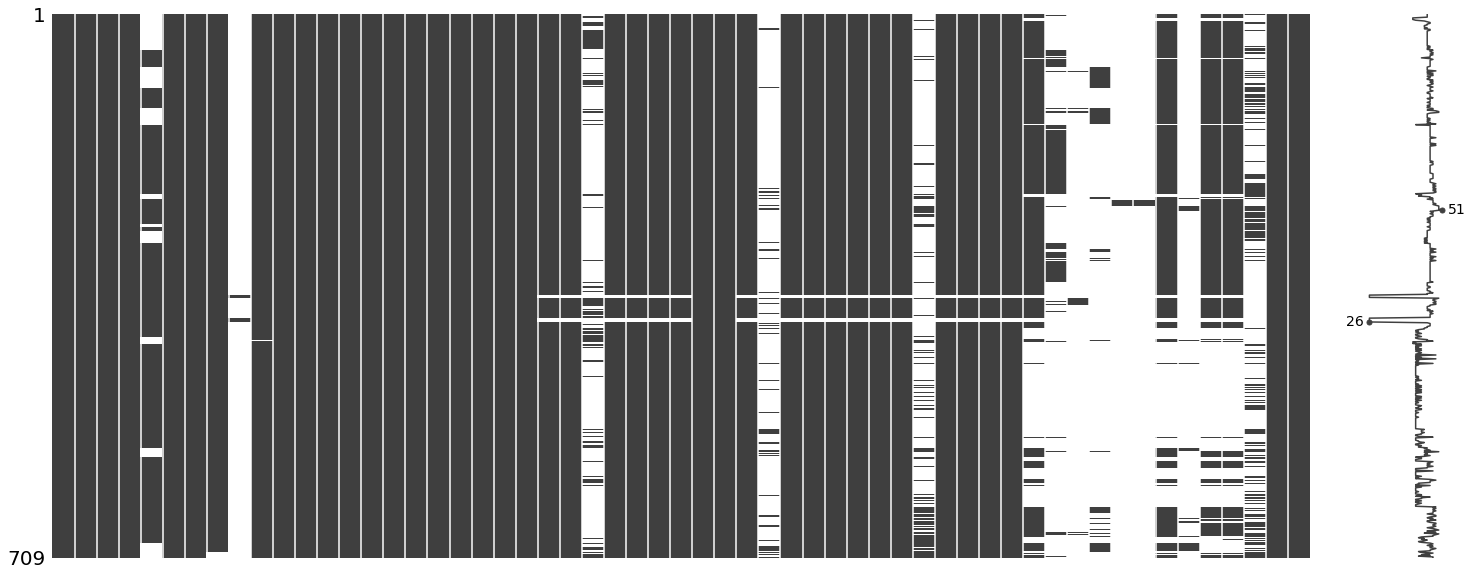

In [5]:
# Missingness
msno.matrix(data)

#### Obervation:
As is often the case with real data, we are confronted with missing data, particularly concerning remarks written by controllers. Does this mean that these trees have nothing to report, or that they should be imputed?

### Labels
Now let's look at the variable to be predicted: the tree diagnosis (classification_diagnosis).

In [6]:
data.classification_diagnostic.unique().shape , data.classification_diagnostic.unique()

((6,), array(['C2', 'C1', 'C3', 'C4', nan, 'C5'], dtype=object))

In [7]:
data.classification_diagnostic.value_counts(dropna=False)

classification_diagnostic
C2     398
C1     237
C3      43
C4      11
NaN     10
C5      10
Name: count, dtype: int64

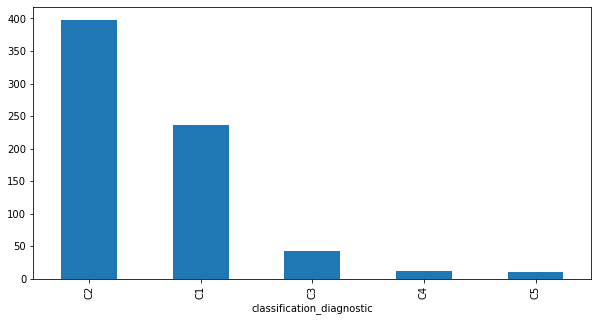

In [8]:
ax_pub = data.classification_diagnostic.value_counts(normalize=False).plot(kind='bar', figsize=(10, 5))

#### Observation:
Surprisingly, we are dealing with a **unbalanced classification problem**. In fact, we count more healthy trees or trees with simple lesions that are not serious (C1 / C2) than trees with irreparable lesions requiring felling (C5).

And yet, these are the most important cases in our study, as we'd like to be able to prevent rather than cure or replace. 

This challenge requires you to handle ad-hoc balanced classification!

### Preprocessing of features
Let's devide them into the three categories we mentioned.

In [9]:
description_features_cat = ['type_sol',
                        'classe_age',
                        'classe_hauteur',
                        'classe_circonference',
                        'vigueur_pousse',
                        'plaie_collet',
                        'fissure_tronc',
                        'plaie_tronc',
                        'fissure_houppier',
                        'bois_mort_houppier',
                        'plaie_houppier',
                        'prescription_1',
                        'prescription_2',
                        'prescription_3',
                        'type_delai_1',
                        'type_delai_2']
description_features_string=  ["ID_ARBRE",
                               'commune',
                               'quartier',
                               'site',
                               'cote_voirie',
                               'genre_arbre',
                               'espece_arbre',
                               'situation',
                               'port_arbre',
                               'champignon_collet',
                               'insecte_collet',
                               'observation_collet',
                               'champignon_tronc',
                               'insecte_tronc',
                               'rejet_tronc',
                               'tuteurage_arbre',
                               'canisse_arbre',
                               'observation_tronc',
                               'champignon_houppier',
                               'insecte_houppier',
                               'ecorce_incluse_houppier',
                               'observation_houppier',
                               'contrainte',
                               'date_diagnostic',
                               'observation_travaux'
                               ]
description_features_num = ['matricule_arbre',
                            'controle',
                            'surf_permeable',
                            'date_plantation',
                            'hauteur',
                            'diametre',
                            'circonference (en cm)',
                            'esperance_maintien',
                            'Long',
                            'Lat'
                            ]
target_features = ['classification_diagnostic']

In [10]:
data[description_features_num]

,matricule_arbre,controle,surf_permeable,date_plantation,hauteur,diametre,circonference (en cm),esperance_maintien,Long,Lat
0,7,NaN,5.0,2000,1000,63.661977,100,1.0,2.074,48.899
1,8,NaN,5.0,2000,1000,60.478878,95,1.0,2.074,48.899
2,9,NaN,5.0,2000,1000,54.112681,85,1.0,2.074,48.899
3,1,NaN,100.0,1980,1600,63.661977,100,1.0,2.073,48.900
4,2,NaN,100.0,1980,1600,190.985932,300,1.0,2.074,48.899
...,...,...,...,...,...,...,...,...,...,...
704,4,NaN,1.0,2000,500,22.281692,35,1.0,2.089,48.898
705,5,NaN,1.0,2017,500,12.732395,20,3.0,2.089,48.899
706,6,NaN,1.0,2000,500,25.464791,40,1.0,2.089,48.899
707,7,NaN,1.0,2019,500,15.915494,25,2.0,2.089,48.899


#### Observation
-We note that the numerical variables are not normalized. Is this necessary?

In [11]:
# We concatenate all of this into a nice datafame
X_cat= data[description_features_cat]
X_string = data[description_features_string]
X_num = data[description_features_num]
X = pd.concat([X_cat, X_string, X_num], axis=1)
y = data[target_features]

In [12]:
X

,type_sol,classe_age,classe_hauteur,classe_circonference,vigueur_pousse,plaie_collet,fissure_tronc,plaie_tronc,fissure_houppier,bois_mort_houppier,...,matricule_arbre,controle,surf_permeable,date_plantation,hauteur,diametre,circonference (en cm),esperance_maintien,Long,Lat
0,P,A,H2,C2,P,RCPLNS,TPF,TPLNC,HPF,HBMI,...,7,NaN,5.0,2000,1000,63.661977,100,1.0,2.074,48.899
1,P,A,H2,C2,P,RCPPL,TPF,TPLC,HPF,HBMI,...,8,NaN,5.0,2000,1000,60.478878,95,1.0,2.074,48.899
2,P,A,H2,C2,P,RCPPL,TPF,TPLCF,HPF,HBMI,...,9,NaN,5.0,2000,1000,54.112681,85,1.0,2.074,48.899
3,G,A,H4,C2,P,RCPPL,TPF,TPLS,HPF,HBMI,...,1,NaN,100.0,1980,1600,63.661977,100,1.0,2.073,48.900
4,G,A,H4,C6,P,RCPPL,TPF,TPLS,HPF,HBMI,...,2,NaN,100.0,1980,1600,190.985932,300,1.0,2.074,48.899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,Gr,A,H1,C1,P,RCPPL,TPF,TPPL,HPF,HPBM,...,4,NaN,1.0,2000,500,22.281692,35,1.0,2.089,48.898
705,Gr,J,H1,C1,D,RCPPL,TPF,TPPL,HPF,HPBM,...,5,NaN,1.0,2017,500,12.732395,20,3.0,2.089,48.899
706,Gr,A,H1,C1,P,RCPPL,TPF,TPLNC,HPF,HPBM,...,6,NaN,1.0,2000,500,25.464791,40,1.0,2.089,48.899
707,Gr,J,H1,C1,PP,RCPPL,TPF,TPPL,HPF,HPBM,...,7,NaN,1.0,2019,500,15.915494,25,2.0,2.089,48.899


In [13]:
y

,classification_diagnostic
0,C2
1,C2
2,C2
3,C2
4,C2
...,...
704,C2
705,C2
706,C2
707,C2


<AxesSubplot:>

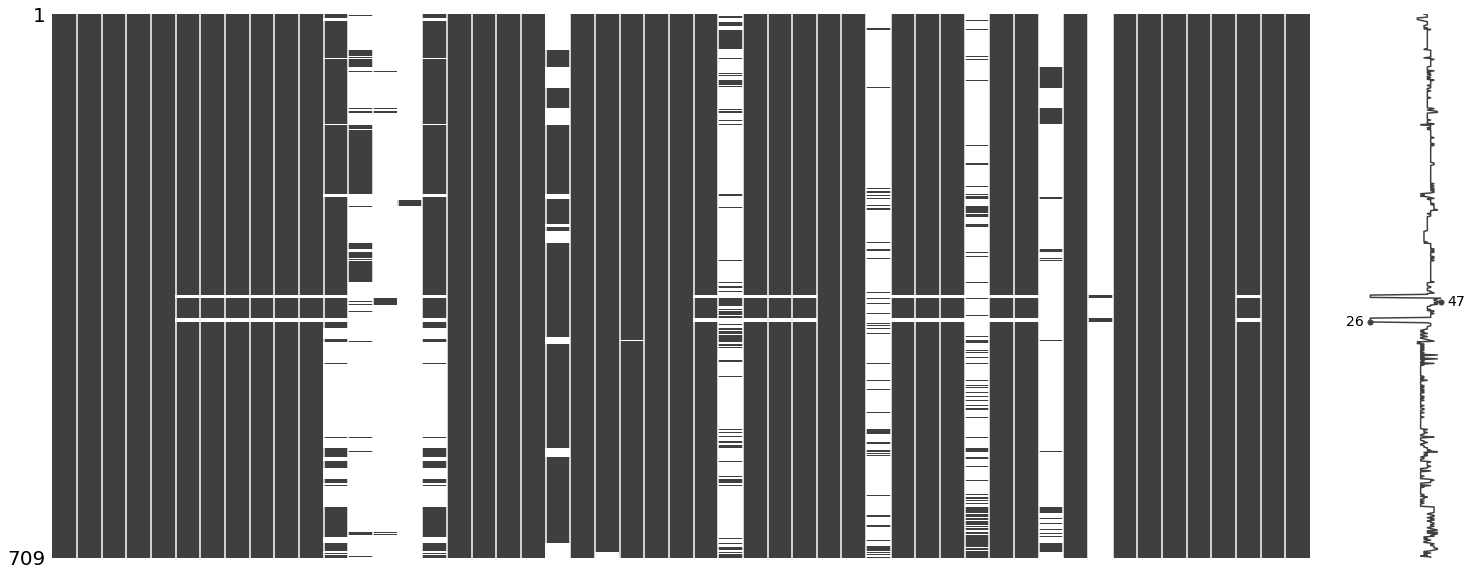

In [14]:
msno.matrix(X)

In [15]:
# Hard code int_to_cat dict and retrieve cat_to_int with dictionary comprehension to use in all needed files
int_to_cat = {
    -1: "NaN",
    0: "C2",
    1: "C1",
    2: "C3",
    3: "C4",
    4: "C5"
}

cat_to_int = {v: k for k, v in int_to_cat.items()}

In [16]:
# We encode our target
y_encoded = np.array(y['classification_diagnostic'].map(cat_to_int).fillna(-1).astype('int8'))
np.unique(y_encoded), y_encoded.shape

(array([-1,  0,  1,  2,  3,  4], dtype=int8), (709,))

### Our baseline model <a class="anchor" id="base_model"></a>

In [17]:
# We split into train/test set
X_train, X_test, y_train , y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=42)

In [18]:
# Let's define a simple pipeline as a simple model
string_transformer = ColumnTransformer(
    [("string", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1000), description_features_string),
     ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1000), description_features_cat)])

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
             ("scaler", StandardScaler())]
)
clf = Pipeline(
    steps=[("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", RandomForestClassifier(random_state=42))]
)
clf.fit(X_train, y_train)
clf

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['ID_ARBRE', 'commune',
                                                   'quartier', 'site',
                                                   'cote_voirie', 'genre_arbre',
                                                   'espece_arbre', 'situation',
                                                   'port_arbre',
                                                   'champignon_collet',
                                                   'insecte_collet',
                                                   'observation_collet',
                                                   'champignon_tronc',
                                                   'insecte_tronc',
                                                   'rejet_tr...
                                                   'plaie_collet',
                                                   'fissure_tronc',
                                                   'plaie_tronc',
                                                   'fissure_houppier',
                                                   'bois_mort_houppier',
                                                   'plaie_houppier',
                                                   'prescription_1',
                                                   'prescription_2',
                                                   'prescription_3',
                                                   'type_delai_1',
                                                   'type_delai_2'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('scaler', StandardScaler())])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [19]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8461538461538461

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         4
           0       0.82      0.92      0.87       120
           1       0.88      0.91      0.90        89
           2       1.00      0.18      0.30        17
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2

    accuracy                           0.85       234
   macro avg       0.62      0.50      0.51       234
weighted avg       0.85      0.85      0.82       234



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


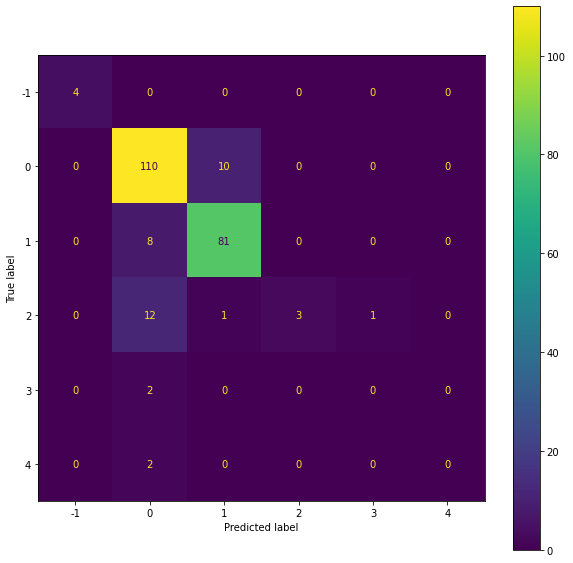

In [21]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)  

#### Observation:
We naively see good performance with a simple ramdom forest. However, don't get us wrong, the problem was unbalanced and we can see from the confusion matrix that errors are always made on the same class!

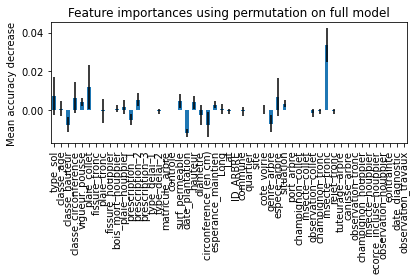

In [22]:
#Let's find our which features contributes the most to the diagnosis
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean,
                                index=description_features_cat+
                               description_features_num+
                               description_features_string)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [23]:
balanced_accuracy_score(y_test, y_pred)

0.5005416024087538

#### Observation
- Unsurprisingly, the presence of insects, the circumference of the trunk and the species are vital information for diagnosing and therefore predicting the tree's condition. But is this the end of the story?
- As expected, the balanced performance of our first model is not very good (50% for 6 classes). It's up to you to do better! 

## Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then sign up to the event [urban trees](https://github.com/AntoineTSP/Ramp_challenge). Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox]() and write the code for your classifier directly on the browser. You can also create a new folder `my_submission` in the `submissions` folder containing `classifier.py` and upload this file directly. You can check the starting-kit ([`classifier.py`](/edit/submissions/starting_kit/classifier.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](). Once it is trained, your submission shows up on the [public leaderboard](). 
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions](). You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the [leaderboard]() is the balenced accuracy score (`bal_acc`). When the score is good enough, you can submit it at the RAMP.

### Submit
Here is the script proposed as the starting_kit:

In [24]:
%%writefile submissions/starting_kit/classifier.py

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

description_features_cat = ["type_sol",
                            'classe_age',
                            'classe_hauteur',
                            'classe_circonference',
                            'vigueur_pousse',
                            'plaie_collet',
                            'fissure_tronc',
                            'plaie_tronc',
                            'fissure_houppier',
                            'bois_mort_houppier',
                            'plaie_houppier',
                            'prescription_1',
                            'prescription_2',
                            'prescription_3',
                            'type_delai_1',
                            'type_delai_2']
description_features_string = ["ID_ARBRE",
                               'commune',
                               'quartier',
                               'site',
                               'cote_voirie',
                               'genre_arbre',
                               'espece_arbre',
                               'situation',
                               'port_arbre',
                               'champignon_collet',
                               'insecte_collet',
                               'observation_collet',
                               'champignon_tronc',
                               'insecte_tronc',
                               'rejet_tronc',
                               'tuteurage_arbre',
                               'canisse_arbre',
                               'observation_tronc',
                               'champignon_houppier',
                               'insecte_houppier',
                               'ecorce_incluse_houppier',
                               'observation_houppier',
                               'contrainte',
                               'date_diagnostic',
                               'observation_travaux'
                               ]
description_features_num = ['matricule_arbre',
                            'controle',
                            'surf_permeable',
                            'date_plantation',
                            'hauteur',
                            'diametre',
                            'circonference (en cm)',
                            'esperance_maintien',
                            'Long',
                            'Lat'
                            ]
target_features = ['classification_diagnostic']


class Classifier(BaseEstimator):
    def __init__(self):
        self.string_transformer = ColumnTransformer(
            [("string",
              OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1000),
              description_features_string),
             ("cat",
              OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1000), description_features_cat)])

        self.numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                   ("scaler", StandardScaler())])

        self.model = RandomForestClassifier(random_state=42)

        self.pipe = make_pipeline(
            self.string_transformer,
            self.numeric_transformer,
            self.model)

    def fit(self, X, y):
        self.pipe.fit(X, y)

    def predict(self, X):
        return self.pipe.predict(X)

    def predict_proba(self, X):
        return self.pipe.predict_proba(X)
    

Overwriting submissions/starting_kit/classifier.py


You can test your solution locally by running the ramp-test command followed by --submission <my_submission folder>.

Here is an example with the starting_kit submission:

Don't forget to install the ramp library with the command:

!pip install ramp-workflow

In [25]:
!ramp-test --submission starting_kit

Testing Urban trees: towards a clinical study
Reading train and test files from ./data/ ...
Reading cv ...


c:\users\klein antoine\appdata\local\programs\python\python38\lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: [39]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\users\klein antoine\appdata\local\programs\python\python38\lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: [39]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\users\klein antoine\appdata\local\programs\python\python38\lib\site-packages\sklearn\impute\_base.py:558: UserWarning: Skipping features without any observed values: [39]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Training submissions\starting_kit ...
CV fold 0
	score  bal_acc    acc      time
	train    1.000  1.000  0.332228
	valid    0.376  0.352  0.032583
	test     0.752  0.740  0.031946
CV fold 1
	score  bal_acc    acc      time
	train    1.000  1.000  0.204117
	valid    0.523  0.806  0.030257
	test     0.803  0.922  0.029003
CV fold 2
	score  bal_acc    acc      time
	train    1.000  1.000  0.189228
	valid    0.513  0.498  0.030992
	test     0.810  0.800  0.032006
CV fold 3
	score  bal_acc    acc      time
	train    1.000  1.000  0.205319
	valid    0.672  0.827  0.029993
	test     0.874  0.931  0.039001
CV fold 4
	score  bal_acc    acc      time
	train    1.000  1.000  0.182003
	valid    0.390  0.563  0.031283
	test     0.748  0.825  0.039262
----------------------------
Mean CV scores
----------------------------
	score         bal_acc             acc        time
	train       1.0 ± 0.0       1.0 ± 0.0  0.2 ± 0.06
	valid  0.495 ± 0.1074  0.609 ± 0.1826   0.0 ± 0.0
	test   0.797 ± 0.0461  0.